In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import random as rd
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
sns.set_theme(context="notebook")

# from scipy.fft import fft
from numpy.fft import fft,fftfreq

from scipy.stats import f as FDIST
from scipy.stats.distributions import chi2


# Média: 
supondo que média do ruído é zero, se média da distribuição for maior que o limiar, existe sinal.

In [ ]:
def ord_MEDIA(sinal, AMPLITUDES=0):
    # media do sinal espontâneo (ruído)
    # considerando aqui que sinal.shape = (SNR = fixada, amostras/indivíduos, amplitudes)
    ORD =  np.mean(sinal, axis = AMPLITUDES)
    return [sinal, ORD]


# SFT: Spectral F-Test

<img src = "sft.png"/>

In [ ]:
def ord_SFT(sinal, tamanhoLaterais, fSinal=-1, fAmostragem=-1):
    if fAmostragem == -1 and fSinal==-1:
        print('Retornando fft:')
        SINAL = fft(sinal)

        return [SINAL,np.zeros(np.shape(sinal))]

    elif fSinal*fAmostragem <0:
        if fSinal== -1:
            print('Necessário argumento de frequência do SINAL ORIGINAL!')

        if  fAmostragem== -1:
            print('Necessário argumento de frequência do SINAL ORIGINAL!')
        
        return [np.zeros(np.shape(sinal)),np.zeros(np.shape(sinal))]

    else:
        SINAL = fft(sinal)
        freqs = fftfreq(len(sinal))*fAmostragem

        central = round(fSinal*len(sinal)/fAmostragem)
        lateralMenor = round(central-tamanhoLaterais/2)
        lateralMaior = round(central+tamanhoLaterais/2)+1

        DEN =np.abs(SINAL[freqs==fSinal])**2
        SINAL_lateral = np.array(list(SINAL[lateralMenor:central])+list(SINAL[central+1:lateralMaior])) 
        NUM = (1/tamanhoLaterais)*np.sum(np.abs(SINAL_lateral)**2)
        SFT = DEN/NUM
    
    return [SINAL,SFT]

# CSM: Component Synchrony Measure 

<img src = "csm.png"/>

In [ ]:
def ord_CSM(sinal, tamanhoJanela, M):
    if len(sinal)-tamanhoJanela*M>=0:
        
        sinal = np.reshape(sinal[0:tamanhoJanela*M], (tamanhoJanela,M))

        SINAL = fft(sinal)

        CSM = (np.sum(np.cos(np.angle(SINAL)),axis=1)/M)**2 + (np.sum(np.sin(np.angle(SINAL)),axis=1)/M)**2

        return [SINAL,CSM]
    else:
        print('Erro no número de janelas', tamanhoJanela,'(ou amostras,M =', M,') escolhido.')
        print(len(sinal)-M*tamanhoJanela)
        print('(Retorna 0)')
        return 0 

# MSC: Magnitude-Squared Coherence

<img src = "msc.png"/>

In [ ]:
def ord_MSC(sinal, tamanhoJanela, M):
    # revisar!
    sinal = np.reshape(sinal[0:tamanhoJanela*M], (tamanhoJanela,M))

    SINAL = fft(sinal)
    
    MSC = np.abs(np.sum(SINAL,axis=1))**2 / (M*np.sum(np.abs(SINAL)**2,axis=1))

    return [SINAL,MSC]

# Simulação MC, sinal DC

In [ ]:
def monteCarloSimulations(  
    listaSNRs,
    limiar = -9999,
    alpha = 5/100, 
    nSim = 5*10**4, 
    sinal = np.zeros((5*10**4,)),
    energiaRuido = 1, 
    ruido = 1*rd.randn(5*10**4,),
    M = 300, 
    tamanhoJanela = 100, 
    tamanhoLaterais = 10,
    fSinal = 10,
    fAmostragem = 100, 
    detector='ord_MEDIA'): 
    # Implementar testes nas entradas!
    # Simulação MC:

    probDetec = np.zeros((len(listaSNRs),1))
    if limiar == -9999:
        limiarCalculado = False
    else:
        limiarCalculado = True

    print('Simulando')
    for i, SNRi in enumerate(listaSNRs):
        amplitude = 10**((SNRi/20)*(energiaRuido**2))

        for sim in range(0,nSim):
            sinal[sim] = energiaRuido*rd.randn(1) + amplitude

            if detector=='ord_MEDIA':
                if not(limiarCalculado):
                    ruido = energiaRuido*rd.randn(nSim,)
                    limiar = np.quantile(ruido, 1-alpha)
                    limiarCalculado = True

                [SINAL, ORD] = ord_MEDIA(sinal, AMPLITUDES=0)

            elif detector=='ord_SFT':
                if not(limiarCalculado):
                    limiar = FDIST.isf(1-alpha, 2, 2*tamanhoLaterais)
                    limiarCalculado = True

                [SINAL, ORD] = ord_SFT(sinal, tamanhoLaterais, fSinal, fAmostragem)

            elif detector=='ord_CSM':
                if not(limiarCalculado):
                    limiar = chi2.ppf(1-alpha,df=2)/(2*M)
                    limiarCalculado = True

                [SINAL, ORD] = ord_CSM(sinal, tamanhoJanela, M=M)

            elif detector=='ord_MSC':
                if not(limiarCalculado):
                    limiar = 1- alpha**(1/(M-1))
                    limiarCalculado = True

                [SINAL, ORD] = ord_MSC(sinal, tamanhoJanela, M)

        probDetec[i] = np.mean(ORD>limiar)


    print('Pronto')
    return [sinal, ruido, SINAL, ORD, probDetec, limiar]

# Executando simulações:
## Testando com sinal "CC"

In [220]:
todasSNRs = np.arange(-20,16,1)
numSim = 5*10**3 # 5mil simulações
DC = 5*np.ones((numSim,))

[sinal, ruido, SINAL, ORD, probDetec, limiar] = monteCarloSimulations(listaSNRs = todasSNRs, nSim = numSim,energiaRuido = 0.99, sinal = DC, detector='ord_MEDIA')

Pronto


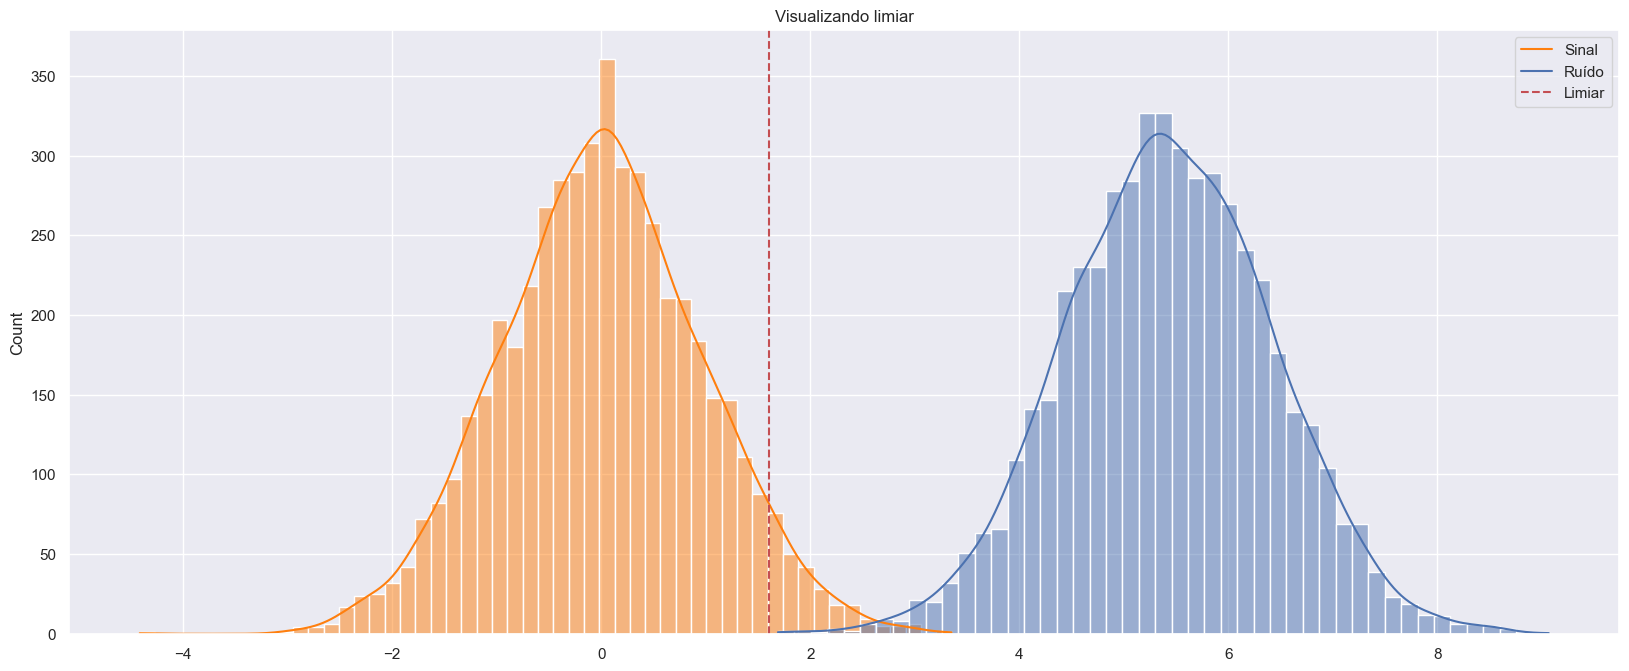

In [221]:
fig,ax = plt.subplots()
sns.histplot(x= ruido, kde= True,ax=fig.axes[0],color='tab:orange')  
sns.histplot(x= sinal, kde= True,ax=fig.axes[0])
plt.axvline(limiar, 0,1,c='r',linestyle='--')
fig.axes[0].set_title('Visualizando limiar')
plt.legend(['Sinal','Ruído','Limiar'])

plt.show()

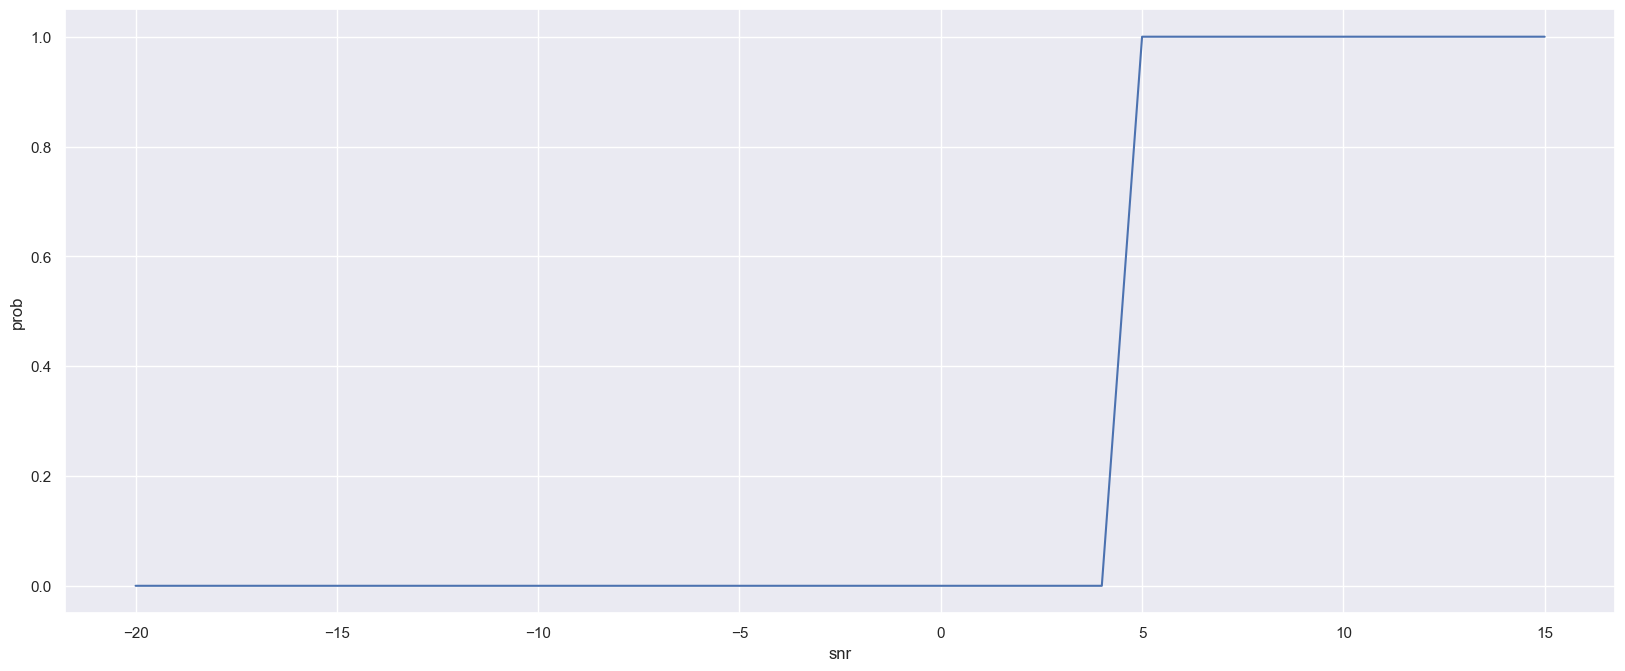

In [222]:
pD = pd.DataFrame({'snr': todasSNRs,'prob':probDetec[:,0]})
sns.lineplot(data = pD,x='snr',y='prob');

# Executando simulações:
## Testando com sinal senoidal

In [223]:
# f = 10  # frequência
# f_s = 100  # taxa de amostragem
# tempo = 1 # segundos

# # Senoide original:
# t2 = np.linspace(start = 0, stop= tempo, num = 10000,endpoint=False)
# senoide = np.sin(f*2*t2*np.pi)

# # Sinal medido:
# t = np.linspace(start=0, stop=tempo, num=tempo * f_s, endpoint=False) 
# SINAL = np.sin(f * 2 * np.pi * t)

# t = np.linspace(start=0, stop=tempo, num=5*10**3, endpoint=False) # t = np.array(range(0, tempo * f_s))  #(?)
# N = 5*10**3

# print(N)
# print(2*np.pi*f/f_s)
# SINAL = np.sin(2*np.pi*f/f_s*t)
# meu = 2*np.pi*f/f_s*t
# print(meu)

# fig, ax = plt.subplots()
# ax.plot(t,SINAL)
# ax.plot(t2,senoide, alpha=0.5)
# ax.set_xlabel('Time [s]')
# ax.set_ylabel('Amplitude')
# ax.set_xlim(0, tempo)
# ax.legend(['Sinal Amostrado', 'Sinal Real']);

# N = 30000
# t = np.array(range(0, N)) #, endpoint=False)
# t = 2*np.pi*f/f_s*t
# SINAL = np.sin(t)
# meu = t
# print(len(t))
# print(len(SINAL))
# print(SINAL.shape)

# fig, ax = plt.subplots()
# ax.plot(t,SINAL)
# ax.set_xlim(0, 5*f_s/(2*np.pi*f))

In [224]:
# X = fft(SINAL)
# freqs = fftfreq(len(SINAL)) * f_s/(2*np.pi*f)
# # * f

# fig, ax = plt.subplots()

# ax.stem(freqs, np.abs(X))
# # ax.stem(np.abs(X))
# ax.set_xlabel('Frequency in Hertz [Hz]')
# ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
# ax.set_xlim(0, f)
# ax.set_ylim(-5, 110);


# print(max(np.abs(X)))
# print(X[freqs == 10])
# print(np.abs(X[freqs==10]))
# print(np.angle(X[freqs==10]))
# print(np.abs(X[freqs==0]))

In [229]:
todasSNRs = np.arange(-20,16,1)
numSim = 5*10**3 # 5mil simulações
M= 300
tamanhoJanela=100
N = M*tamanhoJanela # segundos =tempo * f_s

# Sinal:
N = 30000
t = np.array(range(0, N)) #, endpoint=False)
t = 2*np.pi*f/f_s*t
SINAL = np.sin(t)

# Erro: ruidosa!
# [sinal, ruido, SINAL, ORD, probDetec, limiar] = monteCarloSimulations(listaSNRs = todasSNRs, nSim = numSim,energiaRuido = 0.99, sinal = SINAL, detector='ord_CSM')

# Erro: tudo deu 1
# [sinal, ruido, SINAL, ORD, probDetec, limiar] = monteCarloSimulations(listaSNRs = todasSNRs,
#                                                                             nSim = numSim,
#                                                                             energiaRuido = 0.99,
#                                                                             sinal = SINAL,
#                                                                             fSinal = 10,
#                                                                             fAmostragem = 100,
#                                                                             detector='ord_SFT')

# Erro:
[sinal, ruido, SINAL, ORD, probDetec, limiar] = monteCarloSimulations(listaSNRs = todasSNRs,
                                                                            nSim = numSim,
                                                                            energiaRuido = 0.99,
                                                                            sinal = SINAL,
                                                                            fSinal = 10,
                                                                            fAmostragem = 100,
                                                                            detector='ord_MSC')

Simulando


In [226]:
# fig,ax = plt.subplots()
# sinal = 
# sns.histplot(x= ruido, kde= True,ax=fig.axes[0],color='tab:orange')  
# sns.histplot(x= sinal, kde= True,ax=fig.axes[0])
# plt.axvline(limiar, 0,1,c='r',linestyle='--')
# fig.axes[0].set_title('Visualizando limiar')
# plt.legend(['Sinal','Ruído','Limiar'])

# plt.show()

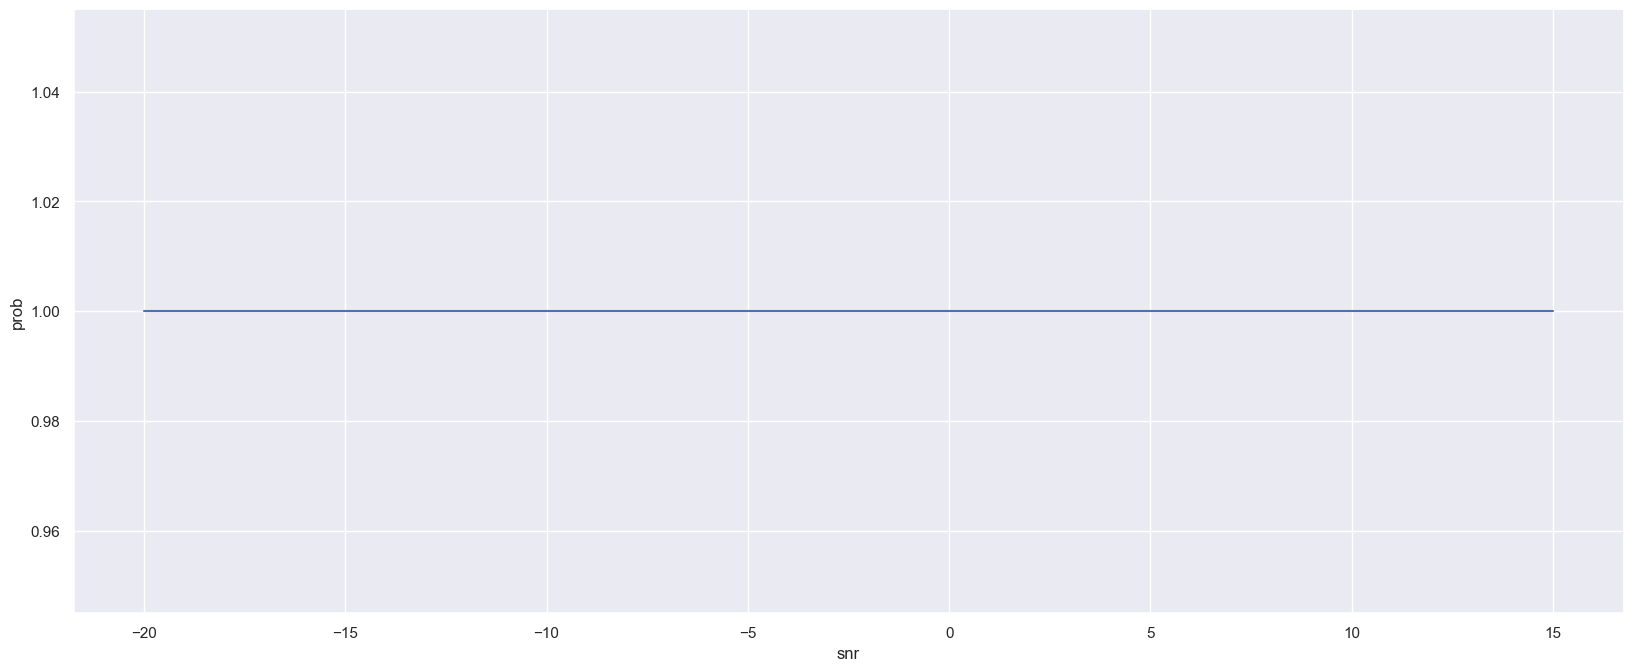

In [ ]:
pD = pd.DataFrame({'snr': todasSNRs,'prob':probDetec[:,0]})
sns.lineplot(data = pD,x='snr',y='prob');

In [228]:
# fig, ax = plt.subplots()
# iiSNR = 1
# # X = fft(ORD[iiSNR][0][:])
# # freqs = fftfreq(len(ORD[iiSNR][0][:])) * f_s

# print(10**(SNRi/20)*(energiaRuido**2))
# sinal = np.sin(2*np.pi*f/f_s*t)
# x = ruido[2,:] +(np.multiply(amplitude,sinal))
# ax.stem(ORD[iiSNR][3][:],linefmt='grey', markerfmt='D')

# iiSNR = -1
# # X = fft(ORD[iiSNR][0][:])
# # freqs = fftfreq(len(ORD[iiSNR][0][:])) * f_s

# print(10**(SNRi/20)*(energiaRuido**2))
# sinal = np.sin(2*np.pi*f/f_s*t)
# x = ruido[2,:] +(np.multiply(amplitude,sinal))

# # ax.stem(freqs, np.abs(X))
# ax.stem(ORD[iiSNR][3][:])
# plt.axhline(limiar, 0,1,c='r',linestyle='--')
# ax.set_xlabel('Frequency in Hertz [Hz]')
# ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
# ax.set_xlim(0, f_s / 2)
# # ax.set_ylim(-5, 110);
# print(limiar)
